<a href="https://colab.research.google.com/github/astrodatos/proyecto_neuralclusters/blob/master/Neural_Clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se predecirá la temperatura efectiva de una estrella a través de sus magnitudes absolutas en cinco bandas fotométricas (problema de regresión). Se ha utilizado la base de datos del SDSS, consultando el mismo a través de astroquery.

In [1]:
!pip install --pre --quiet astroquery

     |████████████████████████████████| 4.3MB 6.6MB/s 
     |████████████████████████████████| 61kB 18.8MB/s 
     |████████████████████████████████| 2.3MB 36.8MB/s 
     |████████████████████████████████| 102kB 24.6MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from time import time
from astroquery.sdss import SDSS

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


print(tf.__version__)

1.14.0-rc1


## Datos del SDSS

Disponible en enlace



###Consulta con Astroquery###

In [0]:
t_ini = time()

data = SDSS.query_sql("""SELECT TOP 5000
                      p.fiberMag_u, p.fiberMag_g, p.fiberMag_r, p.fiberMag_i, 
                      p.fiberMag_z,s.elodieTEff
                   
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO' AND s.class !='GALAXY'
                      
                      """)

In [4]:
datapd=data.to_pandas()
print(datapd)

      fiberMag_u  fiberMag_g  fiberMag_r  fiberMag_i  fiberMag_z  elodieTEff
0       19.97522    18.29667    17.63645    17.41323    17.28637        5059
1       18.54812    17.42075    16.99692    16.81944    16.74287        5720
2       18.92459    17.60666    17.11381    16.92150    16.82598        5467
3       20.52509    18.30592    17.47765    17.19801    17.04544        4775
4       19.01954    17.86671    17.52623    17.40356    17.30230        6162
5       21.77839    18.90348    17.48030    16.04839    15.14471        3717
6       19.60481    17.88959    17.24570    17.03980    16.81905        5059
7       19.03195    17.60430    17.12568    16.92023    16.78967        5467
8       20.61365    18.49613    17.56870    17.10192    16.81956        4576
9       20.39183    18.46844    17.65800    17.29447    17.11287        4576
10      21.09815    18.49171    17.13368    15.77633    15.06088        3717
11      18.30104    17.35975    17.08531    16.92340    16.89254        6000

### Separación entre datos de entrenamiento y datos de prueba 

In [0]:
train_datapd = datapd.sample(frac=0.8,random_state=0)
test_datapd = datapd.drop(train_datapd.index)


### Chequeo a los datos

Estadísticas:

In [6]:
train_stats = train_datapd.describe()
train_stats.pop("elodieTEff")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
fiberMag_u,4000.0,18.124271,158.439250,-9999.00000,19.030195,20.181070,22.190658,26.11051
fiberMag_g,4000.0,19.220439,1.960736,13.54076,17.829973,18.868150,20.305888,25.62909
fiberMag_r,4000.0,18.544417,1.659122,13.08655,17.328432,18.302865,19.722877,23.55924
fiberMag_i,4000.0,18.099536,1.412051,13.06712,17.036568,17.989595,19.218855,22.35431
fiberMag_z,4000.0,17.857038,1.412961,12.84576,16.845135,17.774200,18.672133,22.49046


### Separacaión entre atributos y etiquetas

En este caso, la temperatura es la etiqueta, mientras que los atributos son las magnitudes absolutas en cinco bandas fotométricas.

In [0]:
train_labels = train_datapd.pop('elodieTEff')
test_labels = test_datapd.pop('elodieTEff')

train_feat = train_datapd
test_feat = test_datapd


### Normalización de los datos


In [0]:
#norm train label
def norm(x):
  r=(x-x.mean())/x.std()
  return r

In [9]:

#normtest_temp=tf.keras.utils.normalize(test_labels,axis=0)
train_mean=train_labels.mean()
train_std=train_labels.std()


norm_train_labels=(train_labels-train_mean)/train_std
norm_train_feat = (train_feat - train_feat.mean())/train_feat.std()
print(norm_train_labels)

398    -0.995779
3833    0.428341
4836    0.083946
4572   -0.098490
636    -0.203360
2545   -1.158978
1161   -0.185985
2230    2.119289
148     0.022514
2530   -1.158978
4070   -0.625942
1261    1.188492
4682   -0.068705
333    -0.067464
906     2.429555
3170    1.809024
483     0.192539
2825   -0.830717
1778    0.567961
2466   -0.830717
159    -0.225699
1563   -0.068705
402    -0.995779
4258   -1.158978
4775    2.119289
1095    0.878226
3054   -0.655727
4268    0.257695
3711   -1.002604
453    -0.068705
          ...   
4198   -1.158978
1534   -0.746325
2336   -0.067464
3946   -0.764320
3850   -1.158978
3492    2.119289
2305    0.257695
960    -0.983368
3313   -0.625942
1164    2.119289
371    -1.006948
1306   -1.158978
2993    0.257695
4145    0.567961
3541    0.022514
1575   -1.160840
3742    0.257695
1484    0.878226
3834    0.257695
2548    2.429555
4749   -0.390760
1858    2.119289
258    -0.995779
3835    1.282813
769    -1.071483
2061   -0.484461
4211   -0.131378
2018   -1.1589

Se utilizarán los datos normalizados para entrenar el modelo.


## El modelo

###Estructura de la red neuronal

In [10]:
def build_model():
  model = keras.Sequential([
    layers.Dense(1, activation=tf.nn.tanh, input_shape=[len(train_datapd.keys())]),
    #layers.Dense(5, activation=tf.nn.tanh),
    #layers.Dense(4, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

W0627 16:02:51.265338 140159988897664 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Inspección del modelo

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 6         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

In [12]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  norm_train_feat, norm_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
def desnorm(dato, media, std):
  datonuevo = dato*std + media
  return datonuevo
  

El progreso de entrenamiento del sistema está en el objeto `history`.

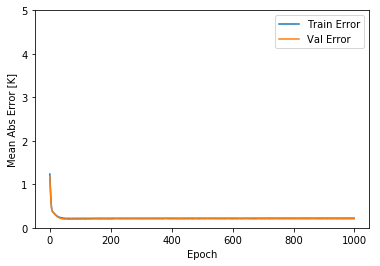

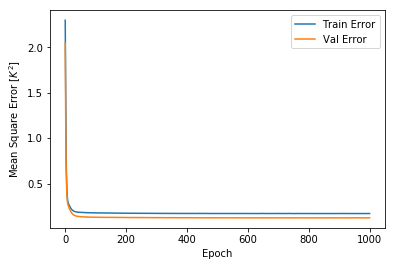

In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

print(history)

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [K]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$K^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

In [0]:
#model = build_model()

# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#history = model.fit(norm_train_feat, train_labels, epochs=EPOCHS,
#                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
#print(history)
#plot_history(history)

In [16]:
norm_test_feat = (test_feat-test_feat.mean())/test_feat.std()
norm_test_labels = (test_labels-test_labels.mean())/test_labels.std()


loss, mae, mse = model.evaluate(norm_test_feat, norm_test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error:  0.20


### Predicción con los datos de prueba

(-679.1004480286738, 14261.10940860215, -625.0, 14315.209856630823)

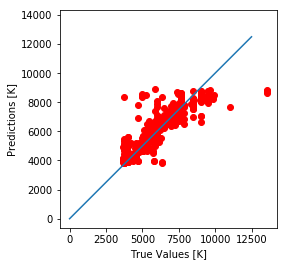

In [17]:
#print(norm_test_labels)

test_predictions = model.predict(norm_test_feat).flatten()
#print(test_predictions)

test_predictions = desnorm(test_predictions, train_mean, train_std)

plt.scatter(test_labels, test_predictions, color='red')
plt.plot([0 , 12500], [0, 12500])
plt.xlabel('True Values [K]')
plt.ylabel('Predictions [K]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,100])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

Notemos que nuestro modelo se acerca a la función de  identidad. Ahora veamos la distribución del error absoluto:



473.0372724533081


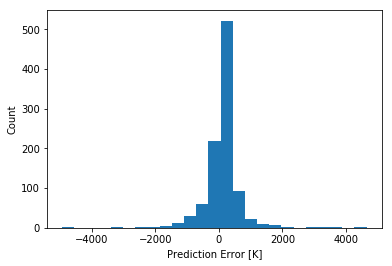

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [K]")
_ = plt.ylabel("Count")

t_fin = time()

print(t_fin - t_ini)